# Ethics and AI : how to prevent bias on ML ? ⚖
*Nathan Lauga*

Hi everyone,
With all the performance that AI can get, it's important to ask ourselves a question : can we understand the algorithm ? Is it fair ?
To answer these questions, I will construct a model based on the US Homicide Reports 1980-2014 that will predict either the sex of the perpetrator or this skin color. 

**The analyse will consist in looking if one of this model is biased on the victim description (sex, skin color) and if so, how to mitigate the bias.**

I'm currently working in general on the aspect of ethics in AI. After this Kernel I will produce an other one concerning the interpretability of AI.

**This notebook is a work version prepared for [IBM event : Watson & Cloud Academy III](https://www-01.ibm.com/events/wwe/grp/grp404.nsf/EventLanding.xsp?openform&seminar=8QZG6KES&locale=fr_FR) in Paris, the 25th september 2019.**

![](https://cdn-images-1.medium.com/max/1000/1*EuQmEYhdjV6xnwn-hFFicQ.jpeg)

*****

## Table of content
* <a href="#1">1. Load and prepare data</a>
    * <a href="#1.1"> 1.1 Load libraries</a>
    * <a href="#1.2"> 1.2 Load the data</a>
* <a href="#2">2. EDA and data preparation</a>
    * <a href="#2.1">2.1 Prepare the data</a>
    * <a href="#2.2">2.2 Handle missing values</a>
    * <a href="#2.3">2.3 Visualization</a>
        * <a href="#2.3.1">2.3.1 Numerical columns</a>
        * <a href="#2.3.2">2.3.2 Categorical columns</a>
    * <a href="#2.4">2.4 Work with feature</a>
        * <a href="#2.4.1">2.4.1 Encoding categorical columns</a>
        * <a href="#2.4.2">2.4.2 Scale numerical columns</a>
* <a href="#3">3. AIF360 Introduction</a>
    * <a href="#3.1">3.1 Create dataset using aif360</a>
    * <a href="#3.2">3.2 First models</a>
* <a href='#4'>4. Bias and Fairness</a>
    * <a href='#4.1'>4.1 Metrics</a>
        * <a href='#4.1.1'>4.1.1 Statistical Parity Difference</a>
        * <a href='#4.1.2'>4.1.2 Equal Opportunity Difference</a>
        * <a href='#4.1.3'>4.1.3 Average Absolute Odds Difference</a>
        * <a href='#4.1.4'>4.1.4 Disparate Impact</a>
        * <a href='#4.1.5'>4.1.5 Theil Index</a>
    * <a href='#4.2'>4.2 How to fix it ?</a>
        * <a href='#4.2.1'>4.2.1 Pre-processing algorithms </a>
            * <a href='#4.2.1.1'>4.2.1.1 Disparate impact remover</a>
            * <a href='#4.2.1.2'>4.2.1.2 Learning fair representations</a>
            * <a href='#4.2.1.3'>4.2.1.3 Optimized preprocessing</a>
            * <a href='#4.2.1.4'>4.2.1.4 Reweighing</a>
        * <a href='#4.2.2'>4.2.2 In-processing algorithms</a>
            * <a href='#4.2.2.1'>4.2.2.1 Adversarial Debiasing</a>
            * <a href='#4.2.2.2'>4.2.2.2 Prejudice Remover Regularizer</a>
        * <a href='#4.2.3'>4.2.3 Post-processing algorithms</a>
            * <a href='#4.2.3.1'>4.2.3.1 Calibrated Equality of Odds</a>
            * <a href='#4.2.3.2'>4.2.3.2 Equality of Odds</a>
            * <a href='#4.2.3.3'>4.2.3.3 Reject Option Classification</a>
    * <a href='#4.3'>4.3 Compare all the algorithms for one attribute</a>
    * <a href='#4.4'>4.4 Compare algorithms performance</a>

*****

## <a id='1'>1. Load and prepare data</a>
### <a id=1.1>1.1 Load libraries</a>

In [1]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

## <a id="1.2">1.2 Load the data</a>

In [2]:
data = pd.read_csv('../input/database.csv', na_values=['Unknown', ' '])

## <a id="2">2. EDA and data preparation</a>

Let's dive into the data and understand what this dataset is about !

### <a id="2.1">2.1 Prepare the data</a>

In [3]:
data.shape

(638454, 24)

In [4]:
data.head().T

,0,1,2,3,4
Record ID,1,2,3,4,5
Agency Code,AK00101,AK00101,AK00101,AK00101,AK00101
Agency Name,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage
Agency Type,Municipal Police,Municipal Police,Municipal Police,Municipal Police,Municipal Police
City,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage
State,Alaska,Alaska,Alaska,Alaska,Alaska
Year,1980,1980,1980,1980,1980
Month,January,March,March,April,April
Incident,1,1,2,1,2
Crime Type,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter


In [5]:
data.columns

Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')

We need to drop the following column : 
* Record ID : it's used to be an id so unique for each record
* Agency Code : can be relevant but it's exactly the same as Agency
* Perpetrator Ethnicity & Age : it corresponds to the target columns

In [6]:
cols_to_drop = ['Record ID', 'Agency Code', 'Perpetrator Ethnicity']
data_orig = data.copy()
data.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = []

In [7]:
def print_missing_values(data):
    data_null = pd.DataFrame(len(data) - data.notnull().sum(), columns = ['Count'])
    data_null = data_null[data_null['Count'] > 0].sort_values(by='Count', ascending=False)
    data_null = data_null/len(data)*100

    trace = go.Bar(x=data_null.index, y=data_null['Count'], marker=dict(color='#c0392b'),
              name = 'At least one missing value', opacity=0.9)
    layout = go.Layout(barmode='group', title='Column with missing values in the dataset', showlegend=True,
                   legend=dict(orientation="h"), yaxis=dict(title='Percentage of the dataset'))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

In [8]:
print('Number total of rows : '+str(data.shape[0]))
print_missing_values(data)

Number total of rows : 638454


In [9]:
data['Crime Solved'].value_counts()

Yes    448172
No     190282
Name: Crime Solved, dtype: int64

If we want to predict the sex and skin color of the perpretator it's necessary to drop the cases wich are not resolved

In [10]:
data_orig = data.copy()
# data = data_orig

data = data[data['Crime Solved'] == 'Yes']
cols_to_drop += ['Crime Solved']

In [11]:
data['Perpetrator Age category'] = np.where(data['Perpetrator Age'] > 64, 'Elder', np.where(data['Perpetrator Age'] < 25, 'Young', 'Adult'))
# data['Victim Age category'] = np.where(data['Victim Age'] > 64, 'Elder', np.where(data['Victim Age'] < 25, 'Young', 'Adult'))

In [12]:
Y_columns = ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
ignore_columns = ['Crime Solved']
cat_columns = []
num_columns = []

for col in data.columns.values:
    if col in Y_columns+ignore_columns:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    else:
        cat_columns += [col]


### <a id="2.2">2.2 Handle missing values</a>
Now let's handle missing values, there are two cases to handle, numerical and categorical values.
* Numerical values : put the median value of the column instead
* Categorical values : put a value called "Missing value" instead

So the first step is to collect each median value

In [13]:
median_val = pd.Series()
for col in num_columns:
    if col not in cols_to_drop:
        median_val[col] = data[col].median()

In [14]:
median_val

Year                 1995.0
Incident                2.0
Victim Age             30.0
Victim Count            0.0
Perpetrator Count       0.0
dtype: float64

In [15]:
def handle_missing_values(data, median_val):
    df = data.copy()
    for col in df:
        if col in median_val.index.values:
            df[col] = df[col].fillna(median_val[col])
        else:
            df[col] = df[col].fillna("Missing value")
    
    return df

In [16]:
data = handle_missing_values(data, median_val)

### <a id="2.3">2.3 Visualization</a>
#### <a id="2.3.1">2.3.1 Numerical columns</a>

In [17]:
def target_distribution(y_var, data):
    val = data[y_var]

    plt.style.use('seaborn-whitegrid')
    plt.rcParams.update({'font.size': 13})
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    cnt = val.value_counts().sort_values(ascending=True)
    labels = cnt.index.values

    sizes = cnt.values
    colors = sns.color_palette("PuBu", len(labels))

    #------------COUNT-----------------------
    ax1.barh(cnt.index.values, cnt.values, color=colors)
    ax1.set_title('Count plot of '+y_var)

    #------------PERCENTAGE-------------------
    ax2.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%', shadow=True, startangle=130)
    ax2.axis('equal')
    ax2.set_title('Distribution of '+y_var)
    plt.show()

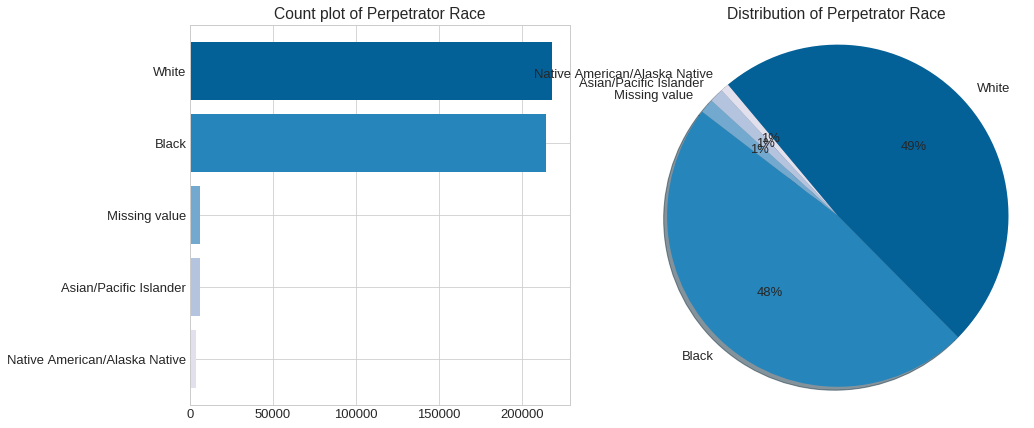

In [18]:
var = 'Perpetrator Race'
target_distribution(y_var=var, data=data)

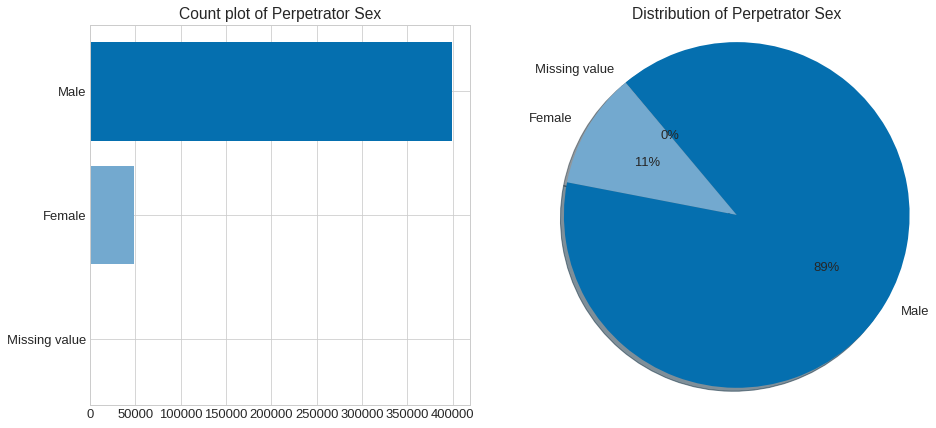

In [19]:
var = 'Perpetrator Sex'
target_distribution(y_var=var, data=data)

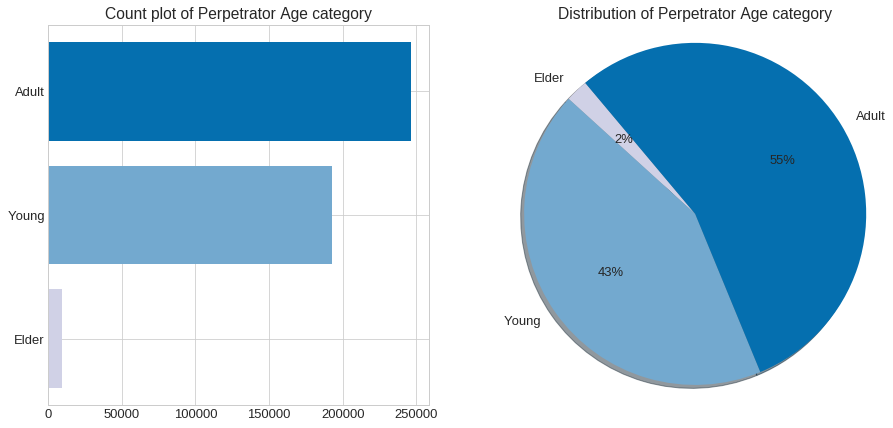

In [20]:
var = 'Perpetrator Age category'
target_distribution(y_var=var, data=data)

In [21]:
data['Frequency'] = 1
freq_target = data[['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category', 'Frequency']]
del data['Frequency']
freq_target = freq_target.groupby(by=['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']).count() / len(data)
print(freq_target.sort_values(by='Frequency', ascending=False))

                                                                        Frequency
Perpetrator Sex Perpetrator Race              Perpetrator Age category           
Male            White                         Adult                      0.264265
                Black                         Young                      0.220366
                                              Adult                      0.197418
                White                         Young                      0.159222
Female          Black                         Adult                      0.035841
                White                         Adult                      0.034741
                Black                         Young                      0.018415
                White                         Young                      0.013767
Male            White                         Elder                      0.013439
                Missing value                 Young                      0.008546
                

If we based our model on the most frequents values we found that by default there is 26% of chance that the perpetrator is a white adult man.

In [22]:
def plot_histo(data, col, Y_columns):
    df = data.copy()
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    
    for i in range(0,2):
        cnt = []; y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt += [df[df[y_col] == val][col].values]
        bins = df[col].nunique()

        axs[i].hist(cnt, bins=bins, stacked=True)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Histogram of the "+col+" column by "+y_col)

    plt.show()

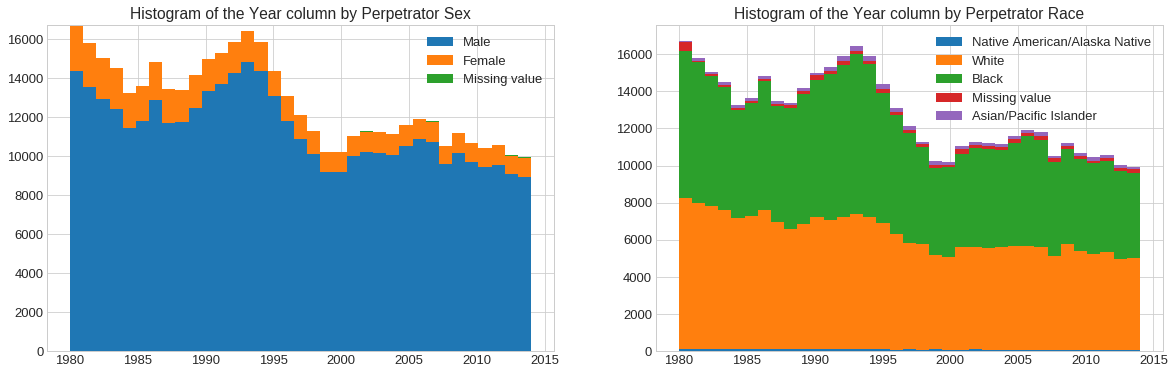

In [23]:
plot_histo(data, col='Year',Y_columns=Y_columns)

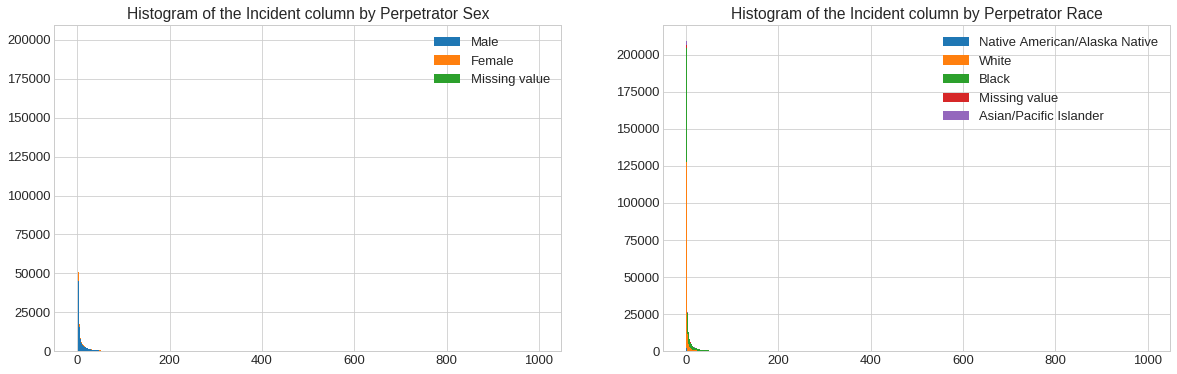

In [24]:
plot_histo(data, col='Incident',Y_columns=Y_columns)

This column is hard to use, so I decided to removed it.

In [25]:
cols_to_drop += ['Incident']

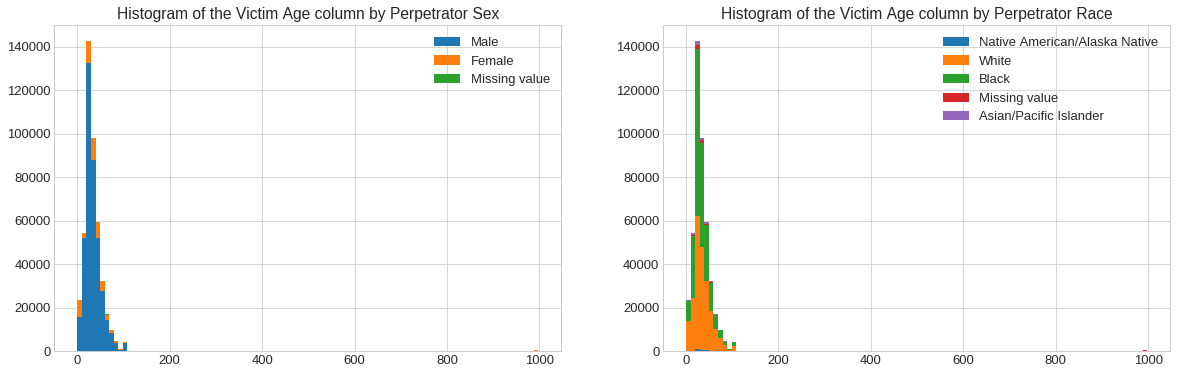

In [26]:
plot_histo(data, col='Victim Age',Y_columns=Y_columns)

With this histogram, it's obvious that there are some outliers.

In [27]:
data[data['Victim Age'] > 100]['Victim Age'].value_counts()

998    369
Name: Victim Age, dtype: int64

With this information that there are 998 years old people in the dataset, we can conclude this is an error, so let's handle these values by replacing them with the median value.

In [28]:
data['Victim Age'] = np.where(data['Victim Age'] == 998, np.median(data[data['Victim Age'] <= 100]['Victim Age']), data['Victim Age'])

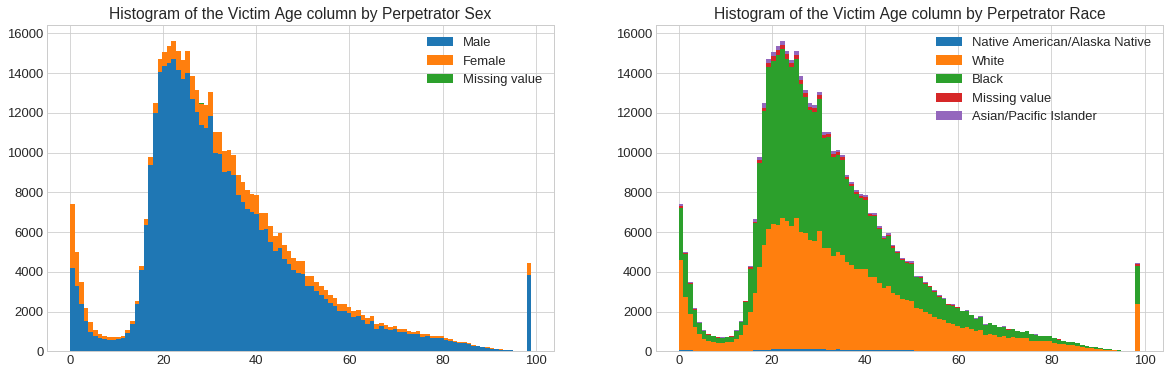

In [29]:
plot_histo(data, col='Victim Age',Y_columns=Y_columns)

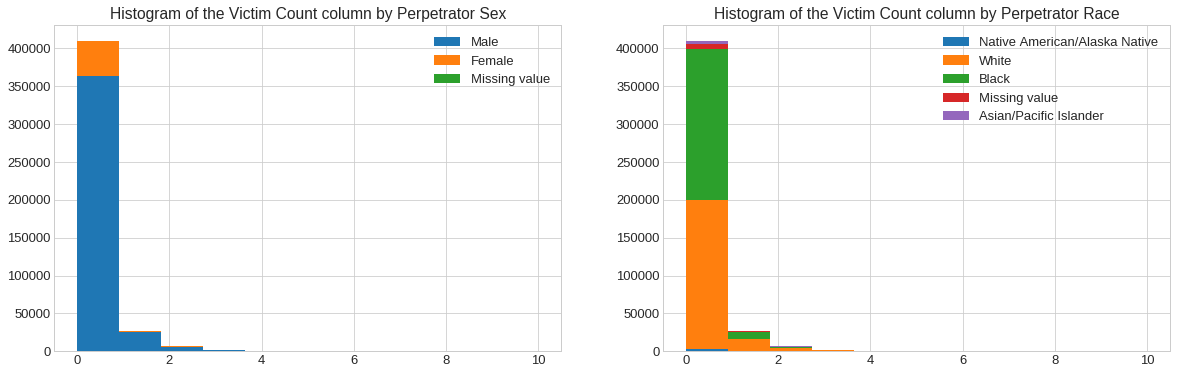

In [30]:
plot_histo(data, col='Victim Count',Y_columns=Y_columns)

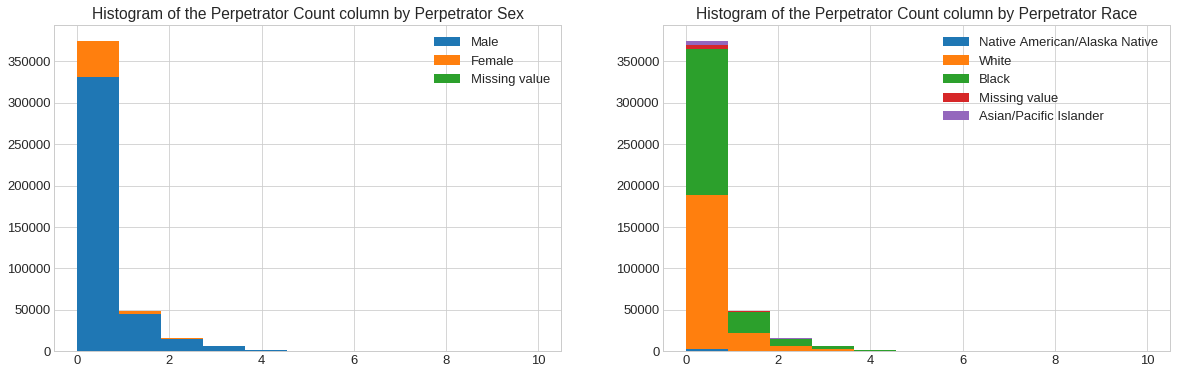

In [31]:
plot_histo(data, col='Perpetrator Count',Y_columns=Y_columns)

#### <a id="2.3.2">2.3.2 Categorical columns</a>

In [32]:
cat_columns

['Agency Name',
 'Agency Type',
 'City',
 'State',
 'Month',
 'Crime Type',
 'Victim Sex',
 'Victim Race',
 'Victim Ethnicity',
 'Perpetrator Age',
 'Relationship',
 'Weapon',
 'Record Source']

In [33]:
def plot_bar(data, col, Y_columns, max_cat=10):
    df = data.copy()
    
    fig, axs = plt.subplots(1,2,figsize=(20,6))
    cat_val = df[col].value_counts()[0:max_cat].index.values
    df = df[df[col].isin(cat_val)]

    for i in range(0,2):
        y_col = Y_columns[i]
        Y_values = df[y_col].dropna().drop_duplicates().values
        for val in Y_values:
            cnt = df[df[y_col] == val][col].value_counts().sort_index()
            axs[i].barh(cnt.index.values, cnt.values)
        axs[i].legend(Y_values,loc='upper right')
        axs[i].set_title("Bar plot of the "+col+" column by "+y_col)

    plt.show()

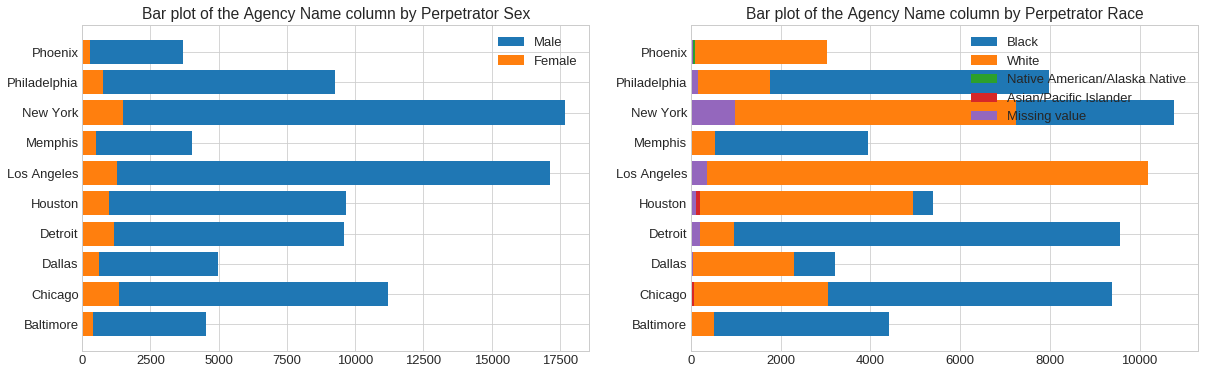

In [34]:
plot_bar(data, col='Agency Name',Y_columns=Y_columns)

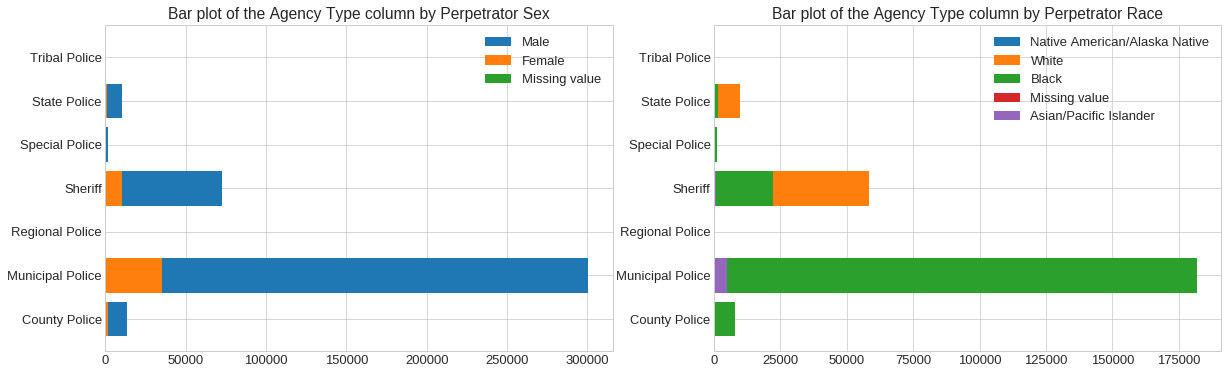

In [35]:
plot_bar(data, col='Agency Type',Y_columns=Y_columns)

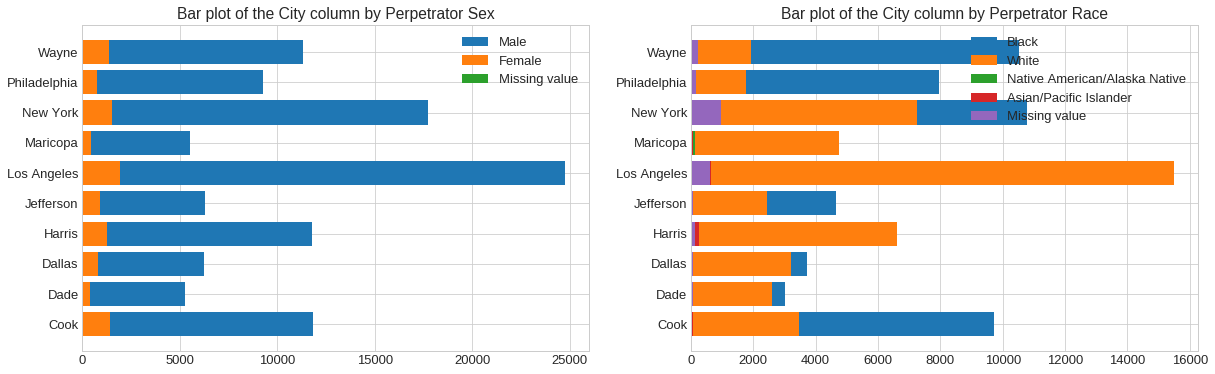

In [36]:
plot_bar(data, col='City',Y_columns=Y_columns)

We have to be carefull about bias for this column, specialy for the skin color value, we can see that some city have more white perpetrator.

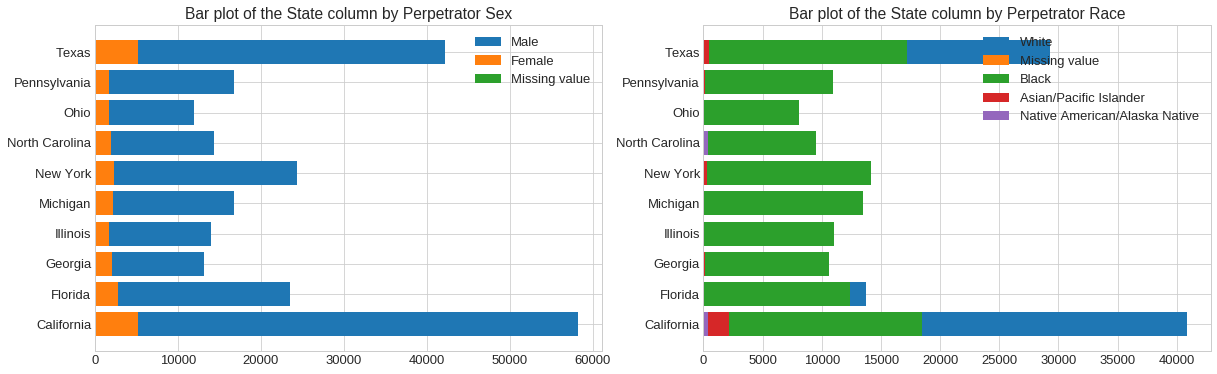

In [37]:
plot_bar(data, col='State',Y_columns=Y_columns)

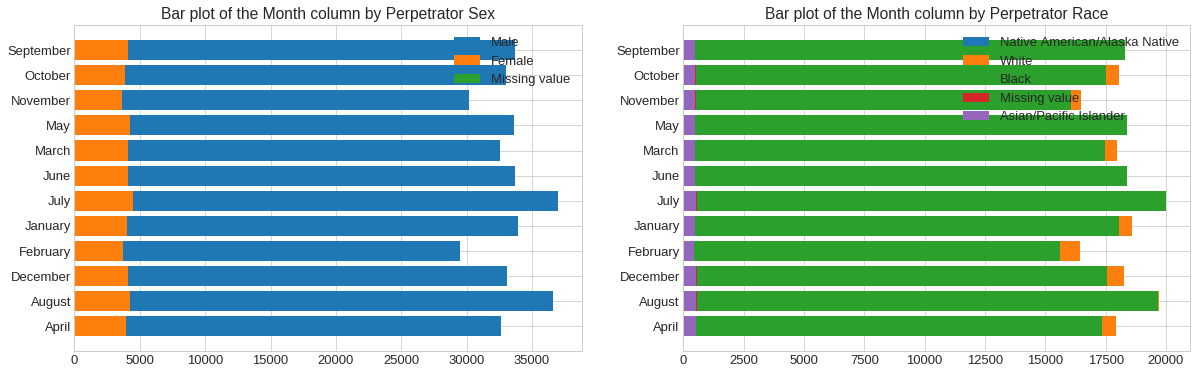

In [38]:
plot_bar(data, col='Month',Y_columns=Y_columns, max_cat=12)

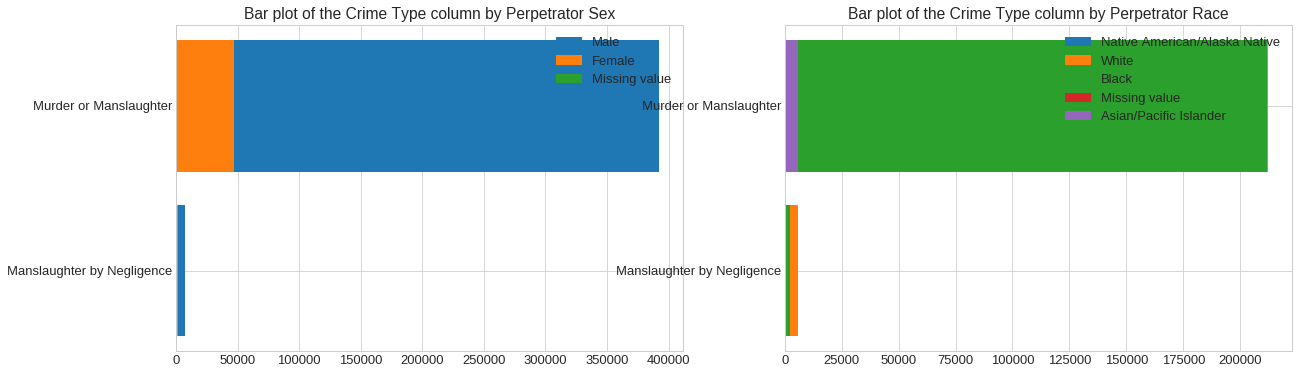

In [39]:
plot_bar(data, col='Crime Type',Y_columns=Y_columns)

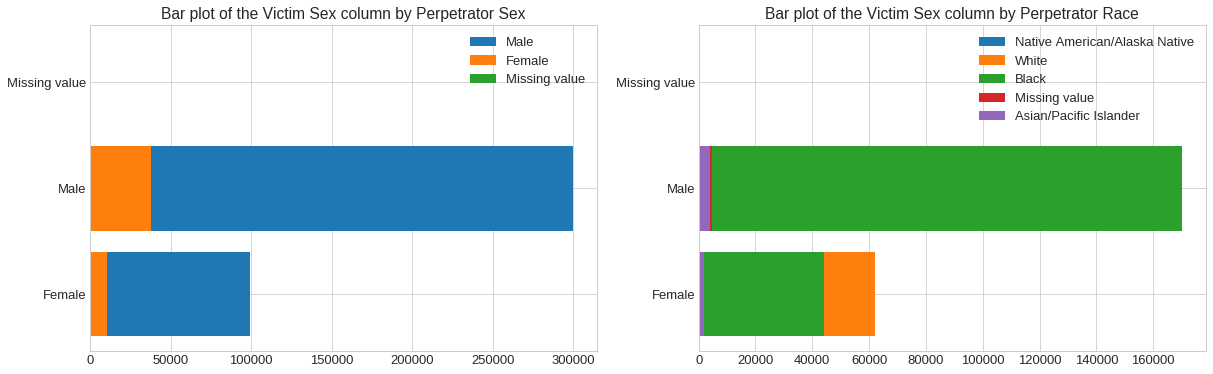

In [40]:
plot_bar(data, col='Victim Sex',Y_columns=Y_columns)

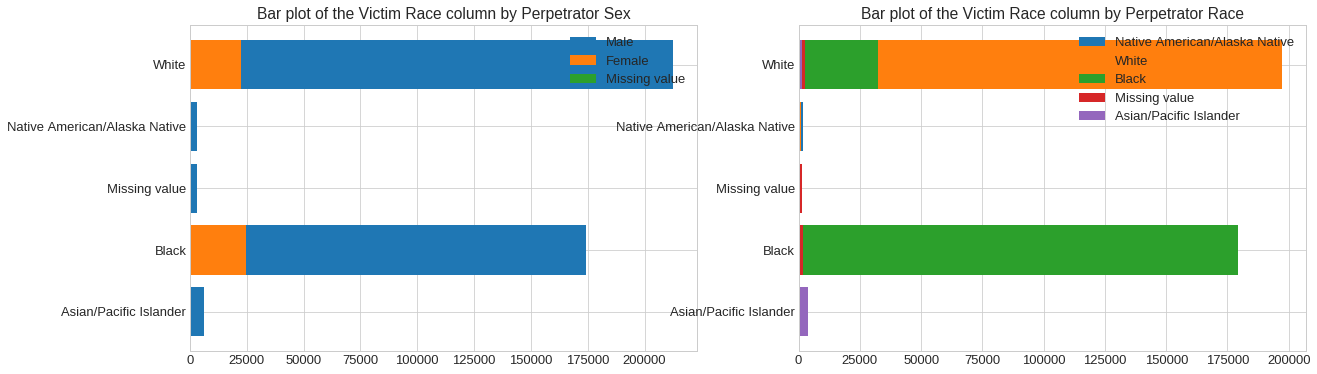

In [41]:
plot_bar(data, col='Victim Race',Y_columns=Y_columns)

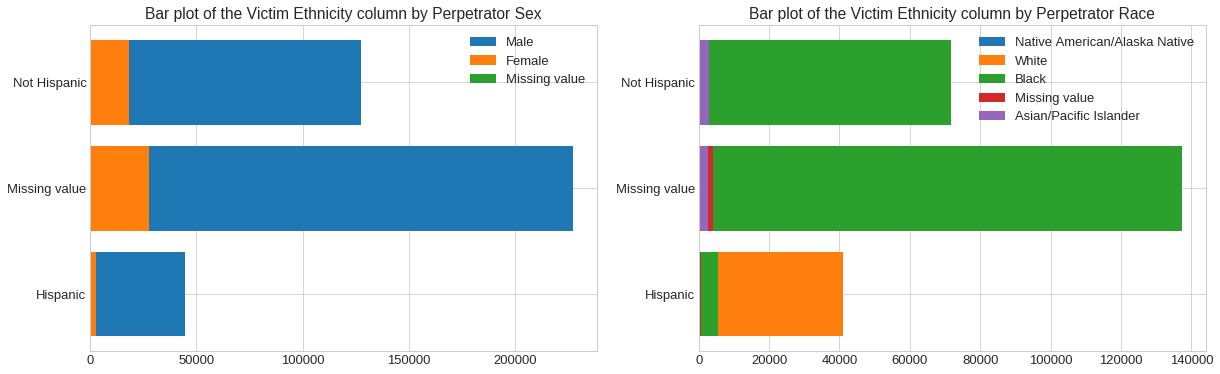

In [42]:
plot_bar(data, col='Victim Ethnicity',Y_columns=Y_columns)

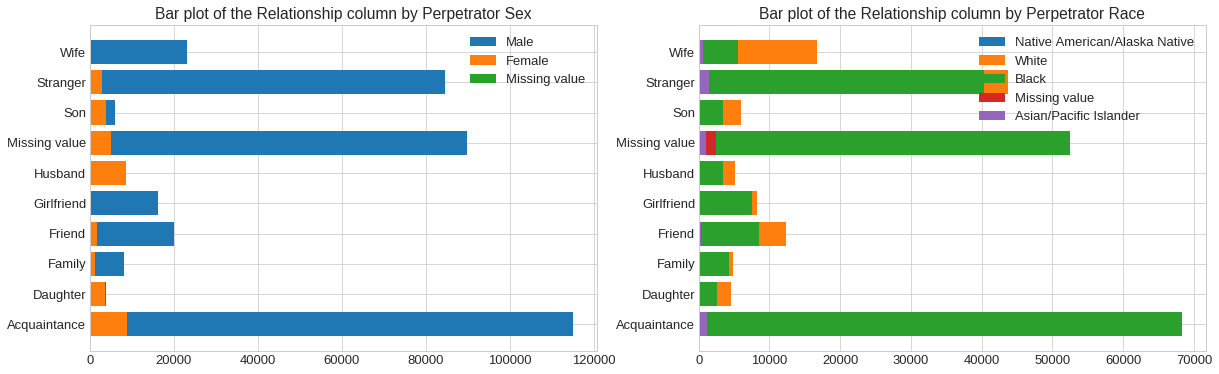

In [43]:
plot_bar(data, col='Relationship', Y_columns=Y_columns)

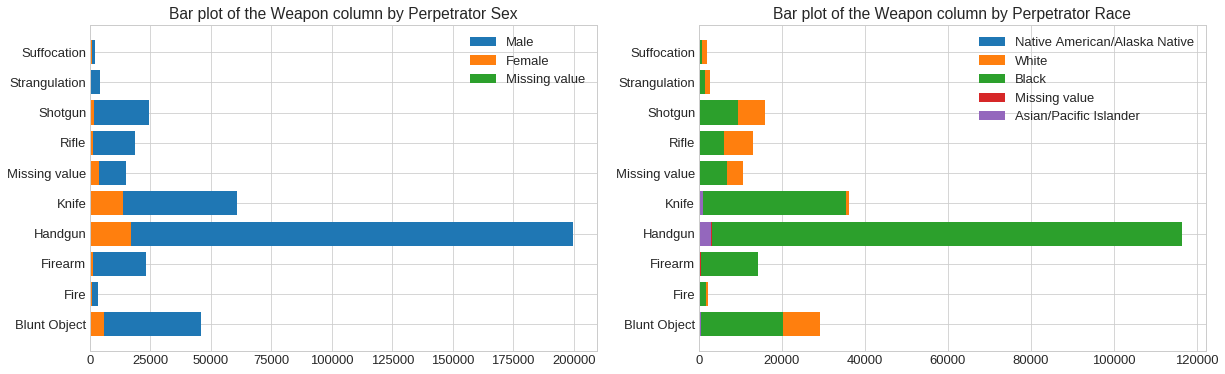

In [44]:
plot_bar(data, col='Weapon', Y_columns=Y_columns)

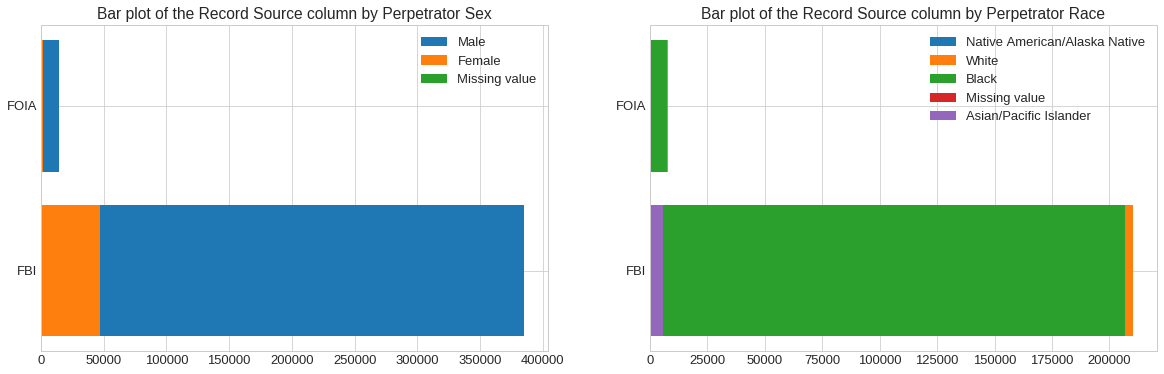

In [45]:
plot_bar(data, col='Record Source', Y_columns=Y_columns)

Now let's drop column that are useless

In [46]:
data.drop(cols_to_drop, axis=1, inplace=True)

### <a id="2.4">2.4 Work with feature</a>
#### <a id="2.4.1">2.4.1 Encoding categorical columns</a>


In [47]:
categorical_features = cat_columns + ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
# categorical_features = categorical_features 
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [48]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

#### <a id="2.4.2">2.4.2 Scale numerical columns</a>

I choose to scale these columns because later in this notebook I will use a neural network so it's necessary to use it.


In [49]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

In [50]:
data_encoded.head()

,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age category
0,146.0,1.0,35.0,1.0,0.0,4.0,1.0,1.0,0.141414,3.0,1.0,1.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
1,146.0,1.0,35.0,1.0,0.0,7.0,1.0,1.0,0.434343,4.0,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
3,146.0,1.0,35.0,1.0,0.0,0.0,1.0,1.0,0.434343,4.0,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
5,146.0,1.0,35.0,1.0,0.0,8.0,1.0,1.0,0.303030,4.0,1.0,1.0,36.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0
6,146.0,1.0,35.0,1.0,0.0,8.0,1.0,0.0,0.424242,3.0,1.0,1.0,27.0,1.0,27.0,9.0,0.0,0.0,0.0,0.0


This dataset is hard to understand for a human so let's create a function that allows us to get back the original values.

In [51]:
def decode_dataset(data, encoders, numerical_features, categorical_features):
    df = data.copy()
    for feat in df.columns.values:
        if feat in numerical_features:
            df[feat] = encoders[feat].inverse_transform(np.array(df[feat]).reshape(-1, 1))
    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [52]:
decode_dataset(data_encoded, encoders=encoders, numerical_features=numerical_features, categorical_features=categorical_features).head()

,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age category
0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,January,Murder or Manslaughter,Male,14.0,Native American/Alaska Native,Missing value,Male,15.0,Native American/Alaska Native,Acquaintance,Blunt Object,0.0,0.0,FBI,Young
1,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,March,Murder or Manslaughter,Male,43.0,White,Missing value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
3,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,April,Murder or Manslaughter,Male,43.0,White,Missing value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
5,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,Murder or Manslaughter,Male,30.0,White,Missing value,Male,36.0,White,Acquaintance,Rifle,0.0,0.0,FBI,Adult
6,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,Murder or Manslaughter,Female,42.0,Native American/Alaska Native,Missing value,Male,27.0,Black,Wife,Knife,0.0,0.0,FBI,Adult


## <a id="3">3. AIF360 Introduction</a>
### <a id="3.1">3.1 Create dataset using aif360</a>

In [53]:
data_perp_sex = data_encoded.drop(['Perpetrator Race','Perpetrator Age category','Perpetrator Age'], axis=1)

In [54]:
privileged_sex = np.where(categorical_names['Victim Sex'] == 'Male')[0]
privileged_race = np.where(categorical_names['Victim Race'] == 'White')[0]

In [55]:
data_orig_sex = StandardDataset(data_perp_sex, 
                               label_name='Perpetrator Sex', 
                               favorable_classes=[1], 
                               protected_attribute_names=['Victim Sex', 'Victim Race'], 
                               privileged_classes=[privileged_sex, privileged_race])

In [56]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dataset shape"))
    print(dataset.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset.feature_names)

In [57]:
meta_data(data_orig_sex)

#### Dataset shape

(448172, 16)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Victim Sex', 'Victim Race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([4.])] [array([0., 2.]), array([0., 1., 2., 3.])]


#### Dataset feature names

['Agency Name', 'Agency Type', 'City', 'State', 'Year', 'Month', 'Crime Type', 'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Relationship', 'Weapon', 'Victim Count', 'Perpetrator Count', 'Record Source']


### <a id="3.2">3.2 First models</a>

I'd like to remember that the goal of this Kernel is not to get a performant model, but the main goal is to find out how we can prevent bias on our model. So I will just construct a simple Random Forest model.

#### Split into train and test set

In [58]:
np.random.seed(42)

data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Perpetrator Sex :",data_orig_sex_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Perpetrator Sex :",data_orig_sex_test.features.shape)

#### Train Dataset shape

Perpetrator Sex : (313720, 16)


#### Test Dataset shape

Perpetrator Sex : (134452, 16)


#### Training the model : classic Random Forest

In [59]:
# Train and save the models
rf_orig_sex = RandomForestClassifier().fit(data_orig_sex_train.features, 
                     data_orig_sex_train.labels.ravel(), 
                     sample_weight=data_orig_sex_train.instance_weights)

### Predict on test set

In [60]:
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

### Performance of the model

In [61]:
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

#### Accuracy of the model :

0.9281825484187666


#### F1 score of the model :

0.9605941887038849


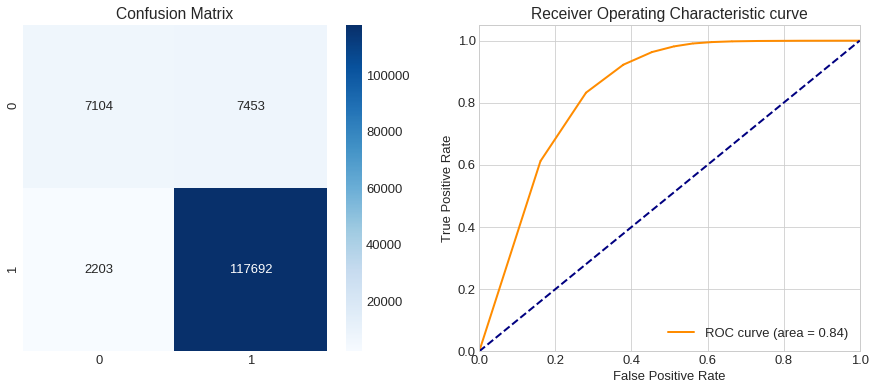

In [62]:
plot_model_performance(rf_orig_sex, data_orig_sex_test.features, y_test_sex)

Both the models have some good metrics (not excellent), so I will use these models for origin models.

## <a id='4'>4. Bias and Fairness</a>

Today, a problem of the model that can be produce by Machine Learning is bias that data can have. So a question is how to measure those bias and how to avoid them. In python there is a package produced by IBM called [aif360](https://github.com/IBM/AIF360) that can gives us some metrics and algorithms to know if our data / model are bias and to get a fair model.

### <a id='4.1'>4.1 Metrics</a>

So with aif360 we have some metrics that indicate if our data or model are bias. I will use 5 metrics : 
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

#### <a id='4.1.1'>4.1.1 Statistical Parity Difference</a>

This measure is based on the following formula : 

$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$

Here the bias or *statistical imparity* is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1.

So it has to be close to **0** so it will be fair.

Also you can find more details about that here : [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)


#### <a id='4.1.2'>4.1.2 Equal Opportunity Difference</a>

This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula :

$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 

Same as the previous metric we need it to be close to **0**.

#### <a id='4.1.3'>4.1.3 Average Absolute Odds Difference</a>

This measure is using both false positive rate and true positive rate to calculate the bias. It's calculating the equality of odds with the next formula :

$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

It needs to be equal to **0** to be fair.

#### <a id='4.1.4'>4.1.4 Disparate Impact</a>

For this metric we use the following formula :

$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$

Like the first metric we use both probabities of a random individual drawn from unprivileged or privileged with a label of 1 but here it's a ratio. 

It changes the objective, for the disparate impact it's **1** that we need.

#### <a id='4.1.5'>4.1.5 Theil Index</a>

This measure is also known as the generalized entropy index but with $\alpha$ equals to 1 (more informations on [the Wikipedia page](https://en.wikipedia.org/wiki/Generalized_entropy_index)). So we can calculate it with this formula :

$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

Where $b_i = \hat{y}_i - y_i + 1 $

So it needs to be close to **0** to be fair.


With these differents metrics we can see that for some we need the prediction and for others just the original dataset. This is why we will use 2 classes of the aif360 package : `ClassificationMetric` and `BinaryLabelDatasetMetric`. 

For the first one we need the prediction so we can have the following metrics : 
* Equal Opportunity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference)
   
`equal_opportunity_difference()`
* Average Absolute Odds Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference)

`average_abs_odds_difference()`
* Theil Index : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.theil_index)

`theil_index()`

Then for the metrics that don't require prediction (the second class) we can use them with the following functions : 
* Statistical Parity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference)

`statistical_parity_difference()`
* Disparate Impact : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.disparate_impact)

`disparate_impact()`


Now I construct a `DataFrame` that will keep the values of the differents metrics I talked just above with a function. 

In [63]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [64]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [65]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

With the function that I created above, we will be abble to look out bias present into the data or the model.

### Bias metrics for the Sex model

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Victim Sex attribute :

With default thresholds, bias against unprivileged group detected in **1** out of 5 metrics

#### For the Victim Race attribute :

With default thresholds, bias against unprivileged group detected in **0** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,0.019663,-0.012576,0.123504,1.021235,0.035653
Victim Race,0.007094,-0.003700,0.008572,1.007535,0.035653


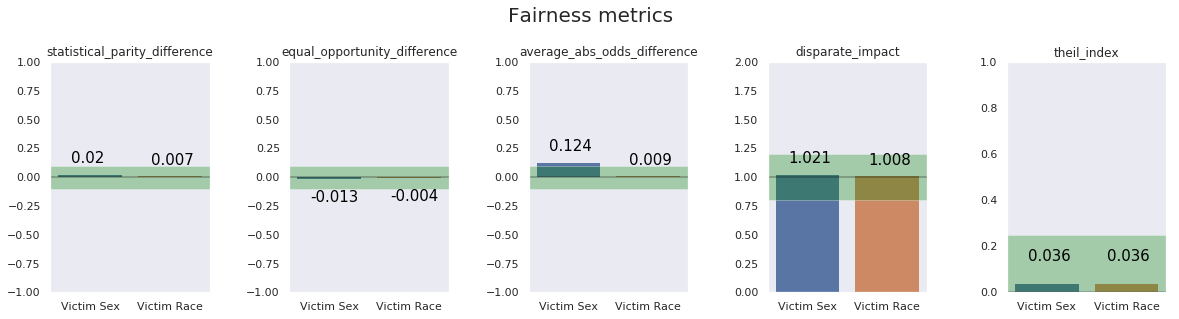

In [66]:
display(Markdown('### Bias metrics for the Sex model'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

As we can see this model is not really biased, but it can be better and for this example we will look how to mitigate those bias.

In [67]:
data_orig_test = data_orig_sex_test
data_orig_train = data_orig_sex_train
rf = rf_orig_sex

probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

As we can see, this first model is biased. The next step is to answer the question : How to fix it ?

### <a id='4.2'>4.2 How to fix it ?</a>

AIF360 use 3 types of algorithms :
* Pre-processing algorithms : they are used before training the model
* In-processing algorithms : they are fair classifiers so it's during the training
* Post-processing algorithms : they are used after training the model

![Fairness pipeline](http://image.noelshack.com/fichiers/2018/50/1/1544437769-fairness-pipeline.png)

This is the **fairness pipeline**. An example instantiation of this generic pipeline consists of loading data into a dataset object, transforming
it into a fairer dataset using a fair pre-processing algorithm, learning a classifier from this transformed dataset, and obtaining
predictions from this classifier. Metrics can be calculated on the original, transformed, and predicted datasets as well as between the
transformed and predicted datasets. Many other instantiations are also possible (more information on [the aif360 paper](https://arxiv.org/pdf/1810.01943.pdf)).

#### <a id='4.2.1'>4.2.1 Pre-processing algorithms </a>

There are 4 pre-processing algorithms but for 3 of them **there is a problem** : it will work only if the dataset have one protected attribute but here we have 2 : *Sex* and *Race*. But let's have a quick intro for all of them and at the end I will use the one that work for my case.

Because this notebook is an exploration of fairness into models I will only use 1 protected attribute : Victim Race, it will allow me to use almost all the algorithms (but for your information the *Reweighing* algo can works with all protected so that's why I will create a function that gives me the protected and unprotected attributes.

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#)



In [68]:
def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names
    
    for attr in selected_attr:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 

    return privileged_groups, unprivileged_groups

*****
##### <a id='4.2.1.1'>4.2.1.1 Disparate impact remover</a>
Source : [Feldman et al., 2015](https://dl.acm.org/citation.cfm?doid=2783258.2783311)

Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups.
If you want to see how it works you can take a look on [an example Notebook from the GitHub of AIF360](https://github.com/IBM/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb).

Some code example :
```
from aif360.algorithms.preprocessing import DisparateImpactRemover
DIR = DisparateImpactRemover()
data_transf_train = DIR.fit_transform(data_orig_train)
```
*****
##### <a id='4.2.1.2'>4.2.1.2 Learning fair representations</a>
Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.
You can find more information on [the demo notebook](https://github.com/IBM/AIF360/blob/master/examples/demo_lfr.ipynb).

In [69]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR_model.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = LFR_model.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'LFR')
print('time elapsed : %.2fs'%(time()-t0))

250 73709995374.92719
500 73709976481.29793
time elapsed : 57.34s


*****
##### <a id='4.2.1.3'>4.2.1.3 Optimized preprocessing</a>
Source : [Calmon et al., 2017](http://papers.nips.cc/paper/6988-optimized-pre-processing-for-discrimination-prevention)

Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives.
There is also [a demo notebook on the aif360 GitHub](https://github.com/IBM/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb).

*To be honest I tried to work with this one but it's more complicated : it uses options that you have to configure yourself and I don't really find how to choose it. Also it use an Optimizer and I didn't find how to build this class. (I didn't read the paper about this algorithm)*
*****
##### <a id='4.2.1.4'>4.2.1.4 Reweighing</a>
Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

In [70]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 13.87s


#### <a id='4.2.2'>4.2.2 In-processing algorithms</a>

It exists 3 in-processing algorithms with aif360. But **I will only use 2** : *Adversarial Debiasing* wich is using TensorFlow and *Prejudice Remover Regularizer*. I'm not using the last one : *ART Classifier*, because I didn't found any documentation that show how it works (maybe I didn't search enough 🙄).

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/inprocessing.html)
*****
#####  <a id='4.2.2.1'>4.2.2.1 Adversarial Debiasing</a>
Source : [Zhang et al., 2018](http://www.aies-conference.com/wp-content/papers/main/AIES_2018_paper_162.pdf)

Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary’s ability to determine the protected attribute from the predictions. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.

In [71]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

# sess.close()
# tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=10,
                          debias=True,
                          sess=sess)

debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')
print('time elapsed : %.2fs'%(time()-t0))

epoch 0; iter: 0; batch classifier loss: 408.924500; batch adversarial loss: 0.644482
epoch 0; iter: 200; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 400; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 600; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 800; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1000; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1200; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1400; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1600; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 1800; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 2000; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 2200; batch classifier loss: nan; batch adversarial loss: nan
epoch 0; iter: 2400; batch classifier loss: nan; batch adversarial loss

*****
##### <a id='4.2.2.2'>4.2.2.2 Prejudice Remover Regularizer</a>
Source : [Kamishima et al., 2012](https://rd.springer.com/chapter/10.1007/978-3-642-33486-3_3)

Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective.

In [72]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="Victim Race", eta = 25.0)
debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 515.46s


#### <a id='4.2.3'>4.2.3 Post-processing algorithms</a>

It exists 3 post-processing algorithms with aif360. 

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/postprocessing.html)

I prepare the predict dataset for all the algorithms that require a dataset with predict scores and labels.

In [73]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

*****
##### <a id='4.2.3.1'>4.2.3.1 Calibrated Equality of Odds</a>
Source : [Pleiss et al., 2017](https://papers.nips.cc/paper/7151-on-fairness-and-calibration)

Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

In [74]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_orig_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      CPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'CalibratedEqOdds')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 2.61s


*****
##### <a id='4.2.3.2'>4.2.3.2 Equality of Odds</a>
Source : [Hardt et al., 2016](https://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning)

Equalized odds postprocessing is a post-processing technique that solves a linear program to find probabilities with which to change output labels to optimize equalized odds.

*I tried to used it, but an error keep happening so this is the code that I wanted to use*

Some code example :
```
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
EOPP = EqOddsPostprocessing(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups,
                             seed=42)
EOPP = EOPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = EOPP.predict(data_orig_test_pred)
```

*****
##### <a id='4.2.3.3'>4.2.3.3 Reject Option Classification</a>
Source : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

In [75]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = ROC.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)

algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      ROC, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'RejectOption')
print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 272.33s


### <a id='4.3'>4.3 Compare all the algorithms for one attribute</a>

In [76]:
def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1, -1, -1, 0, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]
    cols = fair_metrics.columns.values

    for i in range(0, 5):
        col = cols[i]

        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)

        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                       , opacity=0.9, orientation='h')

        layout = go.Layout(barmode='group',
                           title=col,
                           xaxis=dict(range=[bottom[i], bottom[i] + 2]),
                           yaxis=go.layout.YAxis(automargin=True),
                           shapes=[
                               {
                                   'type': 'line',
                                   'x0': min_valid[i],
                                   'y0': -1,
                                   'x1': min_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }, {
                                   'type': 'line',
                                   'x0': max_valid[i],
                                   'y0': -1,
                                   'x1': max_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }])
        fig = go.Figure([trace], layout=layout)
        py.iplot(fig)


def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)

    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(score))]
    colors = [c for c in reversed(colors)]

    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                   , opacity=0.9, orientation='h')
    layout = go.Layout(barmode='group',
                       title='Fairest algorithm',
                       yaxis=go.layout.YAxis(automargin=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)
    

def score_fair_metrics(fair):
    objective = [0, 0, 0, 1, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]

    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)), axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1)
    score = np.array([score, nb_valid])

    score = pd.DataFrame(data=score.transpose(), columns=['score', 'nb_valid'], index=fair.index)
    return score


def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin', 'fair_metrics'].index.values[1:]

    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:, 'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values

    final = pd.DataFrame(data=all_scores, columns=['score', 'nb_valid'], index=algo_metrics.index)
    return final


In [77]:
def compare_fair_metrics(algo_metrics, attr='Victim Race'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score.dropna())

In [78]:
compare_fair_metrics(algo_metrics)

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.007094,-0.003700,0.008572,1.007535,0.035653
LFR,-0.000851,0.000000,0.000000,0.793623,0.000000
Reweighing,0.003852,-0.007360,0.009765,1.004093,0.034822
AdvDebiasing,0.000000,0.000000,0.000000,NaN,2.223135
PrejudiceRemover,0.000000,0.000000,0.000000,1.000000,0.032631
CalibratedEqOdds,0.007094,-0.003700,0.008572,1.007535,0.035653
RejectOption,0.011516,0.000188,0.052711,1.011706,0.028820


,score,nb_valid
PrejudiceRemover,0.032631,5.0
Reweighing,0.059892,5.0
Origin,0.062555,5.0
CalibratedEqOdds,0.062555,5.0
RejectOption,0.104940,5.0
LFR,0.207227,3.0


So now we see that it's the Origin model (Random Forest) is not the fairest one ! 👍

Now let's compare our algorithm for the performance.

### <a id='4.4'>4.4 Compare algorithms performance</a>

In [79]:
def plot_compare_model_performance(algo_metrics, dataset):
    X_test = dataset.features
    y_true = dataset.labels
    perf_metrics = pd.DataFrame()

    models_name = algo_metrics.index.values

    fig = plt.figure(figsize=(7, 7))
    plt.title('ROC curve for differents models')
    lw = 2
    palette = sns.color_palette("Paired")

    for model_name, i in zip(models_name, range(0, len(models_name))):
        model = algo_metrics.loc[model_name, 'model']

        if model_name != 'AdvDebiasing':
            probs = algo_metrics.loc[model_name, 'probs']
            y_pred = algo_metrics.loc[model_name, 'prediction']
            accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

            perf_metrics = perf_metrics.append(
                pd.DataFrame([[accuracy, f1]], columns=['Accuracy', 'F1 Score'], index=[model_name]))
            plt.plot(fpr, tpr, color=palette[i], lw=lw, label=str(model_name) + ' (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    display(perf_metrics.sort_values(by=['Accuracy', 'F1 Score'], ascending=[False, False]))
    plt.show()

,Accuracy,F1 Score
Reweighing,0.929804,0.961469
Origin,0.928183,0.960594
RejectOption,0.908622,0.951248
PrejudiceRemover,0.891731,0.942767
LFR,0.806139,0.891799
CalibratedEqOdds,0.551200,0.677636


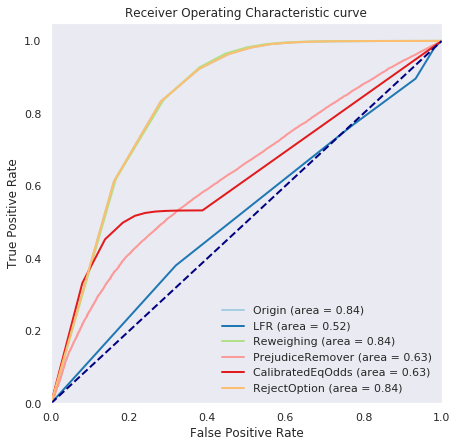

In [80]:
plot_compare_model_performance(algo_metrics, data_orig_test)

So with all this information we see that the most unbiased algorithm is the less performant..

## <a id='5'>5. Practice</a>

This part is construct to exercice yourself with the aif360 package, how to construct a dataset, use some fair metrics and how to mitigate the bias.

You will write code below comments with *TODO* like this :
```
some_code_already_written()

# TODO : print the first 5 rows of the dataset
data.head()
```

The first exercice is to create a `StandardDataset` from the original dataset which we encoded : `data_encoded` 

In the previous part we work with the model that predict the perpetrator sex, now we'll work with the ethnic named **Perpetrator Race**.



In [81]:
# I remove others perpetrator column
columns_to_drop = ['Perpetrator Sex','Perpetrator Age category','Perpetrator Age']
dataset_race = data_encoded.drop(columns_to_drop, axis=1)

In [82]:
dataset_race.head()

,Agency Name,Agency Type,City,State,Year,Month,Crime Type,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,146.0,1.0,35.0,1.0,0.0,4.0,1.0,1.0,0.141414,3.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0
1,146.0,1.0,35.0,1.0,0.0,7.0,1.0,1.0,0.434343,4.0,1.0,4.0,0.0,14.0,0.0,0.0,0.0
3,146.0,1.0,35.0,1.0,0.0,0.0,1.0,1.0,0.434343,4.0,1.0,4.0,0.0,14.0,0.0,0.0,0.0
5,146.0,1.0,35.0,1.0,0.0,8.0,1.0,1.0,0.303030,4.0,1.0,4.0,0.0,12.0,0.0,0.0,0.0
6,146.0,1.0,35.0,1.0,0.0,8.0,1.0,0.0,0.424242,3.0,1.0,1.0,27.0,9.0,0.0,0.0,0.0


To construct your aif360 dataset you need 5 informations :
* the dataset : good you have it ==> `dataset_race`
* the name of your label / target column ==> `'Perpetrator Race'`
* favorable classes of your target column : here it's white but you'll need to get the class number
* columns that contains protected attribute ==> `['Victim Sex', 'Victim Race']` 
* privileged classes for protected attributes : so it's Male and White 

In [83]:
categorical_names['Victim Sex'], categorical_names['Victim Race'], categorical_names['Perpetrator Race'] 

(array(['Female', 'Male', 'Missing value'], dtype=object),
 array(['Asian/Pacific Islander', 'Black', 'Missing value',
        'Native American/Alaska Native', 'White'], dtype=object),
 array(['Asian/Pacific Islander', 'Black', 'Missing value',
        'Native American/Alaska Native', 'White'], dtype=object))

In [84]:
dataset = dataset_race
label_name = 'Perpetrator Race'
protected_attribute_names=['Victim Sex', 'Victim Race']

favorable_classes = np.where(categorical_names['Perpetrator Race'] == 'White')[0]
privileged_sex = np.where(categorical_names['Victim Sex'] == 'Male')[0]
privileged_race = np.where(categorical_names['Victim Race'] == 'White')[0]

In [85]:
privileged_classes = [privileged_sex, privileged_race]

Now let's create the dataset

In [86]:
data_orig_rac = StandardDataset(dataset, 
                               label_name=label_name, 
                               favorable_classes=favorable_classes, 
                               protected_attribute_names=protected_attribute_names, 
                               privileged_classes=[privileged_sex, privileged_race])

You can look at the information with the `meta_data()` function that I created early

In [87]:
meta_data(data_orig_rac)

#### Dataset shape

(448172, 16)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Victim Sex', 'Victim Race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([4.])] [array([0., 2.]), array([0., 1., 2., 3.])]


#### Dataset feature names

['Agency Name', 'Agency Type', 'City', 'State', 'Year', 'Month', 'Crime Type', 'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Relationship', 'Weapon', 'Victim Count', 'Perpetrator Count', 'Record Source']


Next part is the creation of the model, I just use a classic Random Forest, but I encourage you to choose the model of your choice ! :) 

In [88]:
np.random.seed(42)
data_orig_rac_train, data_orig_rac_test = data_orig_rac.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Perpetrator Race : ",data_orig_rac_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Perpetrator Race : ",data_orig_rac_test.features.shape)

#### Train Dataset shape

Perpetrator Race :  (313720, 16)


#### Test Dataset shape

Perpetrator Race :  (134452, 16)


In [89]:
# if you want to change to model be my guest 
model = RandomForestClassifier()
model = model.fit(data_orig_rac_train.features, data_orig_rac_train.labels.ravel())

Let's see the model's performance

#### Accuracy of the model :

0.8630440603337994


#### F1 score of the model :

0.859319133331296


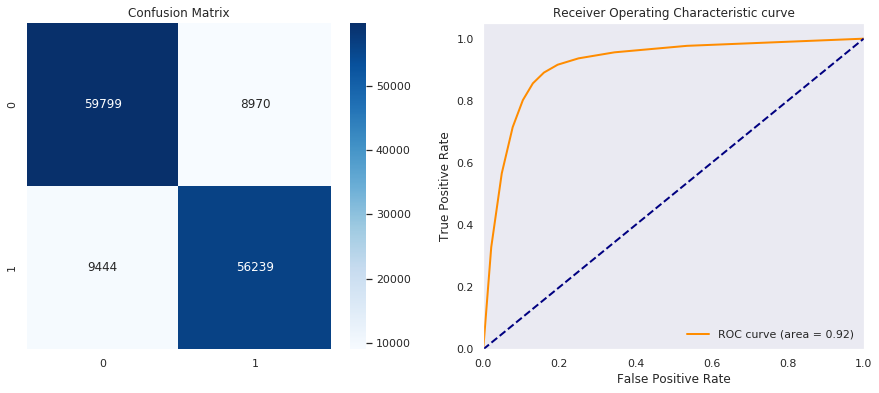

In [90]:
X_test_rac = data_orig_rac_test.features
y_test_rac = data_orig_rac_test.labels.ravel()
plot_model_performance(model, data_orig_rac_test.features, y_test_rac)

Great ! Now we have a `StandardDataset` and a model, let's see if bias are presents.

In [91]:
# we need to create a new dataset with predictions from the model into labels attribute
dataset = data_orig_rac_test
dataset_pred = dataset.copy()
dataset_pred.labels = model.predict(data_orig_rac_test.features)

Now you need to find out if there are bias in the dataset or the model with metrics.

Remember you can see details about metrics here : <a href='#4.1'>4.1 Metrics</a>

You need to construct both `ClassificationMetric` and `BinaryLabelDatasetMetric` classes because with that you'll be able to get the metrics.

First I will do an example to construct both classes for `'Victim Race'` feature then it's you turn for the `'Victim Sex'`

In [92]:
dataset_pred.protected_attribute_names

['Victim Sex', 'Victim Race']

In [93]:
# I get the index of Male and Female classes
privileged_race   = np.where(categorical_names['Victim Race'] == 'White')[0]
unprivileged_race = np.where(categorical_names['Victim Race'] == 'Black')[0]

# I format variable like in the documentation of ClassificationMetric and BinaryLabelDatasetMetric
privileged_groups   = [{'Victim Race' : privileged_race}] 
unprivileged_groups = [{'Victim Race' : unprivileged_race}] 

# I create both classes
classified_metric_race = ClassificationMetric(dataset, 
                                         dataset_pred,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

metric_pred_race = BinaryLabelDatasetMetric(dataset_pred,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

<span style="color:red;">You turn</span>

In [94]:
# TODO : do the same as above but with Victim Sex attribute
privileged_sex   = None
unprivileged_sex = None 

privileged_groups   = [{'' : privileged_sex}] 
unprivileged_groups = [{'' : unprivileged_sex}] 

# Remove comments below
# classified_metric_sex = ClassificationMetric(dataset, 
#                                          dataset_pred,
#                                          unprivileged_groups=unprivileged_groups,
#                                          privileged_groups=privileged_groups)

# metric_pred_sex = BinaryLabelDatasetMetric(dataset_pred,
#                                          unprivileged_groups=unprivileged_groups,
#                                          privileged_groups=privileged_groups)

Now you can use `mean_difference()` and `disparate_impact()` with the `BinaryLabelDatasetMetric` class and `equal_opportunity_difference()`, `average_abs_odds_difference()`, `theil_index()` with `ClassificationMetric` class.

**Remember : all of metrics fair objective is 0 except for `disparate_impact()` which is 1 !**

Now you can use the created classes to check bias into data and model 

In [95]:
def is_fair(metric, objective=0, threshold=0.2):
    return abs(metric - objective) <= threshold

In [96]:
# This is an example for mean_difference metric and race attribute:
my_fair_metric = metric_pred_race.mean_difference()
print(my_fair_metric)

if is_fair(my_fair_metric):
    print('My metric is fair')
else:
    print('My metric is not fair')

-0.8863682829164659
My metric is not fair


<span style="color:red;">You turn</span>

In [97]:
# This is all the code for 4 others fair metrics and victim race attribute
classified_metric_race.equal_opportunity_difference()
classified_metric_race.average_abs_odds_difference()
metric_pred_race.disparate_impact()
classified_metric_race.theil_index()

# TODO : find out which metrics said that this is fair or not. 
#        remember that disparate_impact fair is at 1 and the others at 0
your_metric = 0

In [98]:
# TODO : do the same for the victim sex attribute 
#        metric_pred_sex and classified_metric_sex class




Well done ! You succeed to know if our model needs to be fairest or no. As you can see, it needs to be more fair !

**So let's use some processors to mitigate bias !**

I will do an example for one algorithm and then you will have carte blanche to explore by yourself others algorithms.

In [99]:
# This is a function you can use to get privileged_groups and unprivileged_groups informations
# that are used for processors 

def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names
    
    for attr in selected_attr:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 

    return privileged_groups, unprivileged_groups

In [100]:
# an example
get_attributes(dataset, selected_attr=['Victim Sex'])

([{'Victim Sex': array([1.])}], [{'Victim Sex': array([0., 2.])}])

In [101]:
# also to remember the dataset used for training is this one
dataset = data_orig_rac_train
# and the test one :
dataset_test = data_orig_rac_test

So here I want to use a pre-processor named `Reweighing`, this algorithm set weight for each row during the model training, this is how it's used :

In [102]:
privileged_groups, unprivileged_groups = get_attributes(dataset, selected_attr=['Victim Race'])
t0 = time()

# Creation of the algorithm class
RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# I transform my dataset
data_transf_train = RW.fit_transform(dataset)

# Train and save the model
rf_transf = RandomForestClassifier()
rf_transf = rf_transf.fit(data_transf_train.features, 
                          data_transf_train.labels.ravel(), 
                         sample_weight=data_transf_train.instance_weights) # sample_weight arguments is used thanks to Reweighing class

print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 13.02s


In [103]:
# Now I can predict on the test dataset
data_transf_test = RW.transform(dataset_test)

rf_transf.predict(dataset_test.features)

array([1., 1., 1., ..., 0., 0., 0.])

All you need to play with processors is in this part of the notebook : <a href='#4.2'>4.2 How to fix it ?</a>

If you have any questions, do not hesitate.

<span style="color:red;">You turn</span>

To conclude, this situation is perfect to illustrate a problem that Data Scientists will have to face at least once : **Should I prefer the performance or the fairness of my model ?**

*Spoiler alert : the fairness* 😉

Thanks a lot for reading, sorry for my english I'm not really good at it ! 
Please tell me if there is any improvements that I can make for this kernel.

$Nathan$